# Inspect Results of all 10-Fold MC Dropout Runs

<hr/>

#### Imports

In [19]:
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ensemble_uncertainties.utils.ad_assessment import spearman_coeff

from sklearn.metrics import r2_score

from statistics import median

#### Constants

In [2]:
TASK = 'regression'
DATA_FOLDER = f'~/PowerFolders/ensemble_ad/data/featurized/{TASK}/'
ENSEMBLE_DATA_FOLDER = '~/PowerFolders/ensemble_ad/publication/plotting_notebooks/data/'
DROPOUT_RESULTS_FOLDER = '~/PowerFolders/ensemble_ad/data/results/initial_results/regression_dropout/'
PLOT_FOLDER = './plots/'

#### Settings

In [3]:
mpl.rcParams['figure.dpi'] = 200

algorithms = ['rf', 'xgb', 'svm_rbf', 'shallow', 'dropout']
algorithm_names = ['RF', 'XGB', 'SVM', 'Shallow', 'Deep']
algorithm_to_name = dict(zip(algorithms, algorithm_names))

descriptors = ['maccs', 'ecfc', 'rdkit', 'cddd']
descriptor_names = ['MACCS', 'ECFC', 'RDKit', 'CDDD']
descriptor_to_name = dict(zip(descriptors, descriptor_names))

# Names of the datasets that were already run
dataset_names = [
    'tetrahymena',
    'freesolv',
    'esol',
    'MMP2',
    'IL4',
    'F7',
    'O60674',
    'O14965',
    'P03372',
    'P04150',
    'P06401',
    'P11229',
    'P12931',
    'P16581',
    'P17252',
    'P18089',
    'P19327',
    'P21554',
    'P24530',
    'P25929',
    'P28335',
    'P28482',
    'P35968',
    'P41594',
    'P42345',
    'P47871',
    'P49146',
    'P61169',
    'Q05397',
    'Q16602',
    'P24941',
    'Q92731'
]

#### Functions

In [4]:
def load_true(name):
    """Loads dependent variables of a given dataset."""
    path = f'{DATA_FOLDER}{name}/{name}_y.csv'
    y = pd.read_csv(path, sep=';').set_index('id')
    return y


def load_dropout_results_file(name, descriptor):
    """Loads table with dropout predictions and uncertainties for a given dataset/descriptor."""
    path = f'{DROPOUT_RESULTS_FOLDER}{name}_dropout/{descriptor}/results.csv'
    results_df = pd.read_csv(path, sep=';').set_index('id')
    return results_df


def load_evaluation_matrix(name, evaluation='predictive', to_matrix=True):
    """Loads performance table for a single dataset."""
    path = f'{ENSEMBLE_DATA_FOLDER}/{evaluation}_performances/{name}.csv'
    df = pd.read_csv(path, sep=';').set_index('descriptor')
    if to_matrix:
        matrix = df.to_numpy()
        return matrix
    else:
        return df
    
    
def make_y_range(yrange, interval=.1):
    """Creates a range between yrange[0] and yrange[1] with a given interval."""
    factor = 1./interval
    ylow = int(factor * yrange[0])
    yhigh = int(factor * yrange[1])
    rang = range(ylow, yhigh+1)
    rang_adjusted = [np.round(val*interval, 1) for val in rang]
    return rang_adjusted

<hr/>

#### Load data

In [5]:
dropout_result_tables = dict()

for dataset in dataset_names:
    for descriptor in descriptors:
        results_df = load_dropout_results_file(dataset, descriptor)
        results_df['y'] = load_true(dataset)
        dropout_result_tables[f'{dataset}_{descriptor}'] = results_df

#### Collect overviews

Dropout

In [6]:
complete_overview_dropout = pd.DataFrame()

names = list()
descs = list()
r2_values = list()
rho_values = list()

for dataset in dataset_names:
    for descriptor in descriptors:
        names.append(dataset)
        descs.append(descriptor_to_name[descriptor])
        df = dropout_result_tables[f'{dataset}_{descriptor}']
        r2_values.append(r2_score(df['y'], df['predicted']))
        rho_values.append(spearman_coeff(df['resid'], df['mc_sd']))

complete_overview_dropout['name'] = names
complete_overview_dropout['descriptor'] = descs
complete_overview_dropout['r2'] = r2_values
complete_overview_dropout['rho'] = rho_values

Ensembles

In [7]:
complete_overview_ensemble = pd.DataFrame()

names = list()
descs = list()
r2_values = list()
rho_values = list()

for dataset in dataset_names:
    r2_df = load_evaluation_matrix(dataset, evaluation='predictive', to_matrix=False)
    rho_df = load_evaluation_matrix(dataset, evaluation='uncertainty', to_matrix=False)
    for descriptor in descriptor_names:
        names.append(dataset)
        descs.append(descriptor)
        r2_values.append(r2_df['Deep'][descriptor])
        rho_values.append(rho_df['Deep'][descriptor])

complete_overview_ensemble['name'] = names
complete_overview_ensemble['descriptor'] = descs
complete_overview_ensemble['r2'] = r2_values
complete_overview_ensemble['rho'] = rho_values

#### Scatter plot

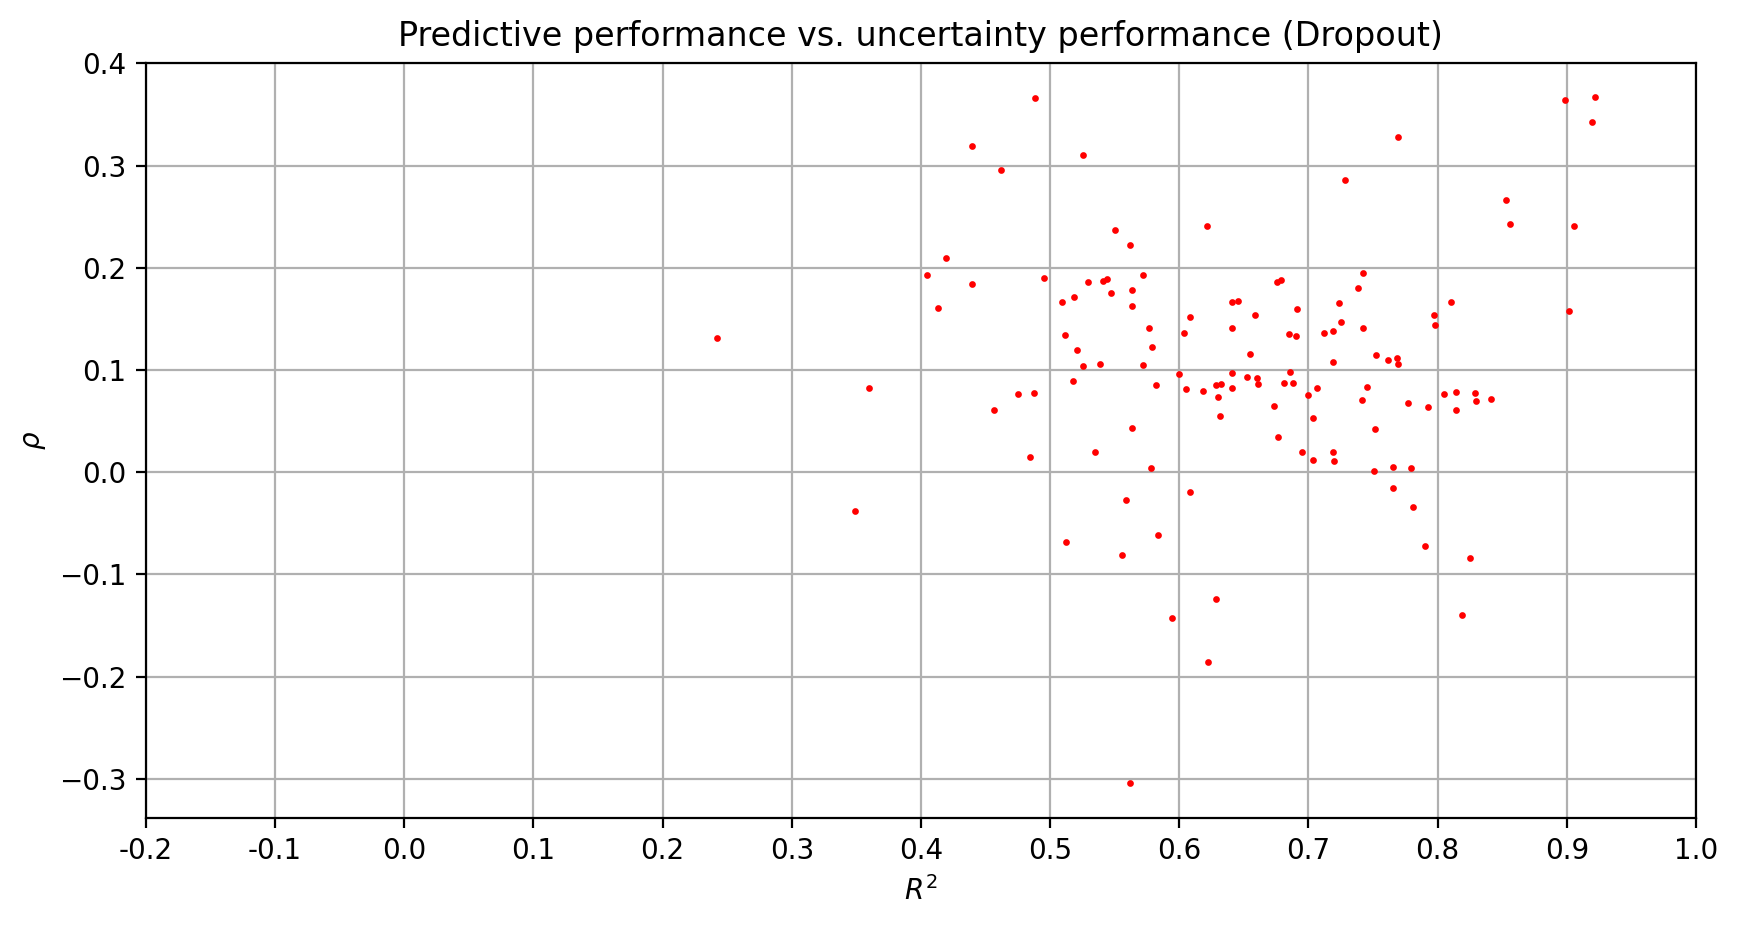

In [8]:
plt.figure(figsize=(10, 5))
plt.grid(zorder=1000)
plt.scatter(complete_overview_dropout['r2'], complete_overview_dropout['rho'], s=2, zorder=100, color='red')
plt.xlabel(r'$R^2$')
plt.xticks(np.arange(-.2, 1.1, .1), [f'{val:.1f}' for val in np.arange(-.2, 1.1, .1)])
plt.ylabel(r'$\rho$')
plt.title('Predictive performance vs. uncertainty performance (Dropout)')
plt.savefig(PLOT_FOLDER+'predictive_vs_uncertainty/dropout_unselected_overview.pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()

#### Box-Whisker: dropout vs. ensembles

Predictive performance

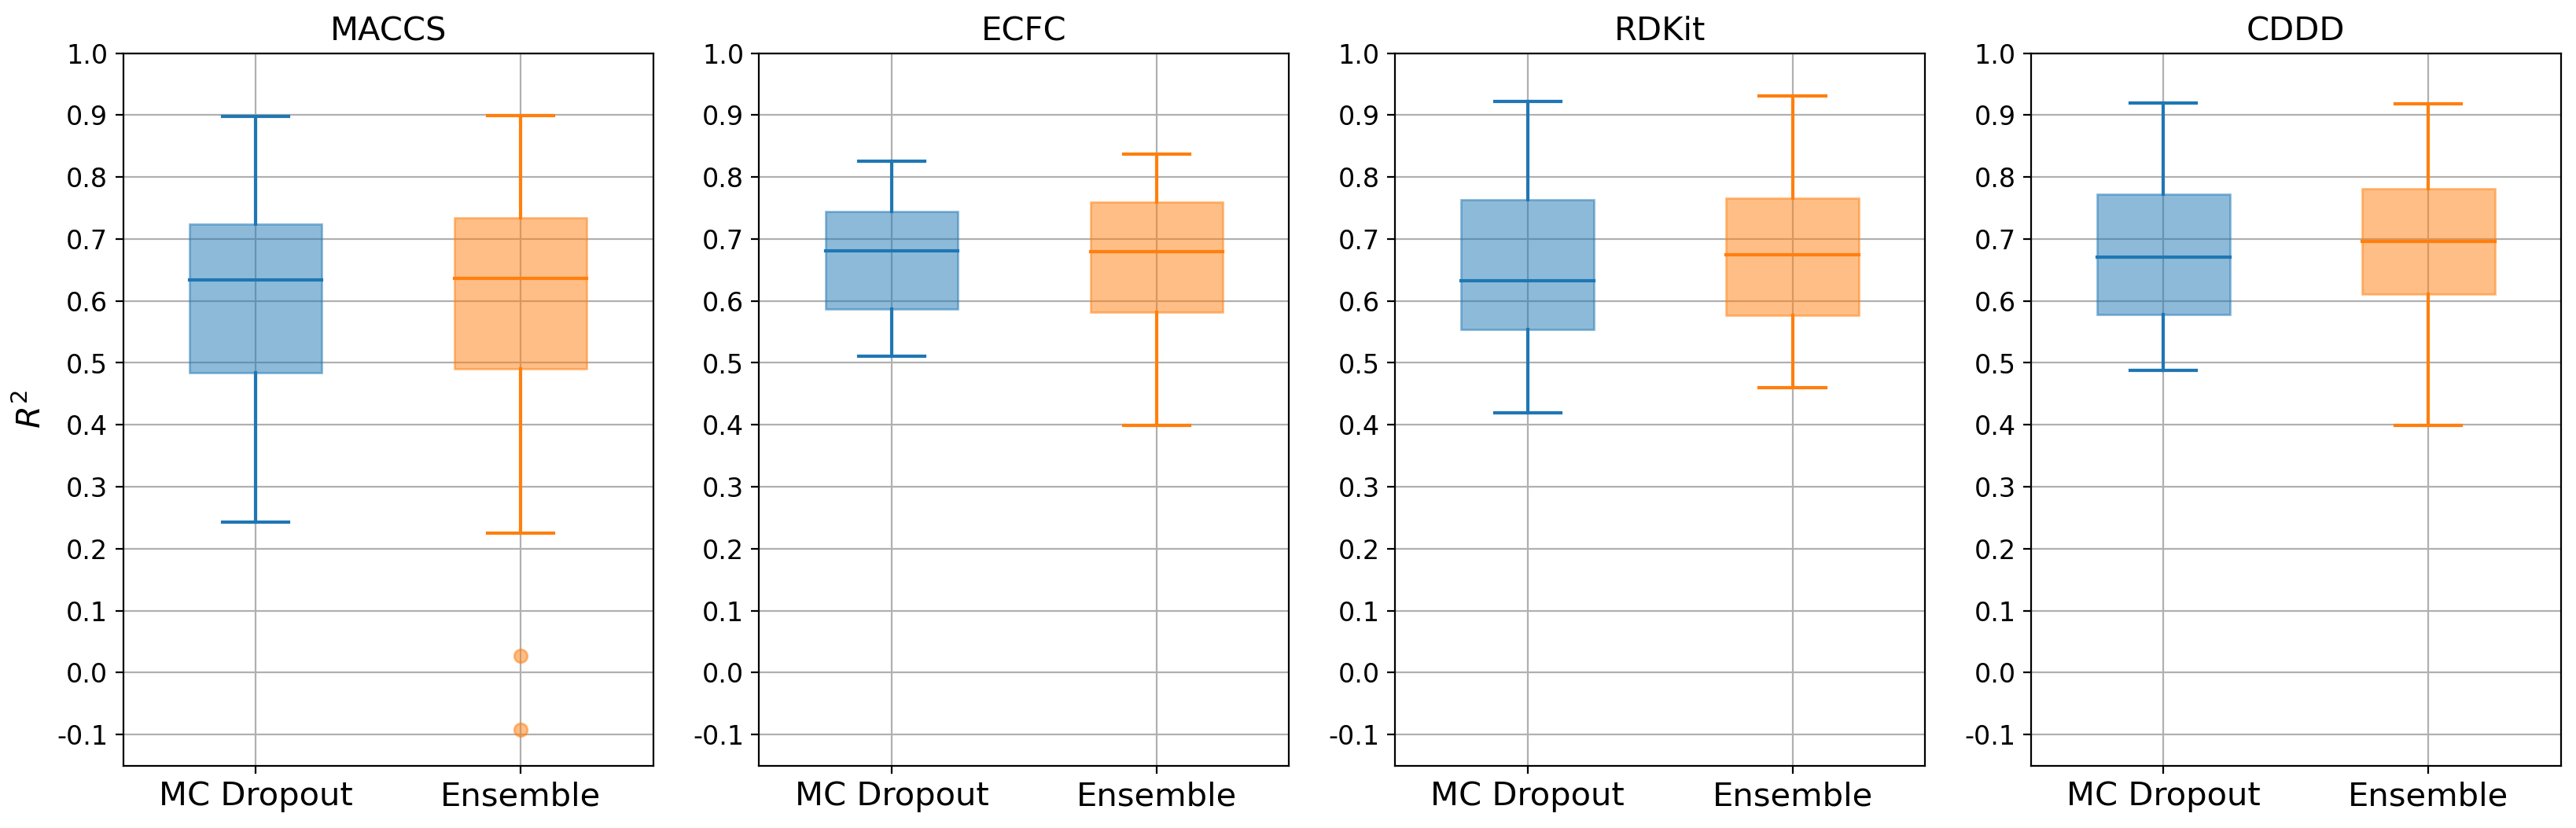

In [9]:
fix, axes = plt.subplots(1, len(descriptors), figsize=(20, 6))

for i in range(len(axes)):
    ax = axes[i]
    descriptor = descriptor_names[i]
    title = descriptor
    dropout_table = complete_overview_dropout[complete_overview_dropout['descriptor'] == descriptor]
    ensemble_table = complete_overview_ensemble[complete_overview_ensemble['descriptor'] == descriptor]
    ax.grid(zorder=1000)
    for j, table in enumerate([dropout_table, ensemble_table]):
        flierprops = {'markerfacecolor':f'C{j}', 'markeredgecolor':f'C{j}', 'alpha':.5}
        box = ax.boxplot(table['r2'], flierprops=flierprops, positions=[j], widths=[.5], patch_artist=True)
        for k, patch in enumerate(box['boxes']):
            patch.set_facecolor(f'C{j}')
            patch.set_edgecolor(f'C{j}')
            patch.set_alpha(.5)
        for patch in box['medians']:
            patch.set_color(f'C{j}')
            patch.set_linewidth(1.5)
        for item in ['whiskers', 'fliers', 'caps']:
            for patch in box[item]:
                patch.set_color(f'C{j}')
                patch.set_linewidth(1.5)
    ax.set_ylim((-.15, 1.))
    ax.set_title(title, size=15)
    ax.set_xticklabels(['MC Dropout', 'Ensemble'], size=15)
    rang_adjusted = make_y_range((-.1, 1.))
    ax.set_yticks(rang_adjusted)
    ax.set_yticklabels(rang_adjusted, size=12)
    if i == 0:
        ax.set_ylabel('$R^2$', size=15)
plt.savefig(PLOT_FOLDER+'dropout_vs_ensemble/r2.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

Uncertainty performance

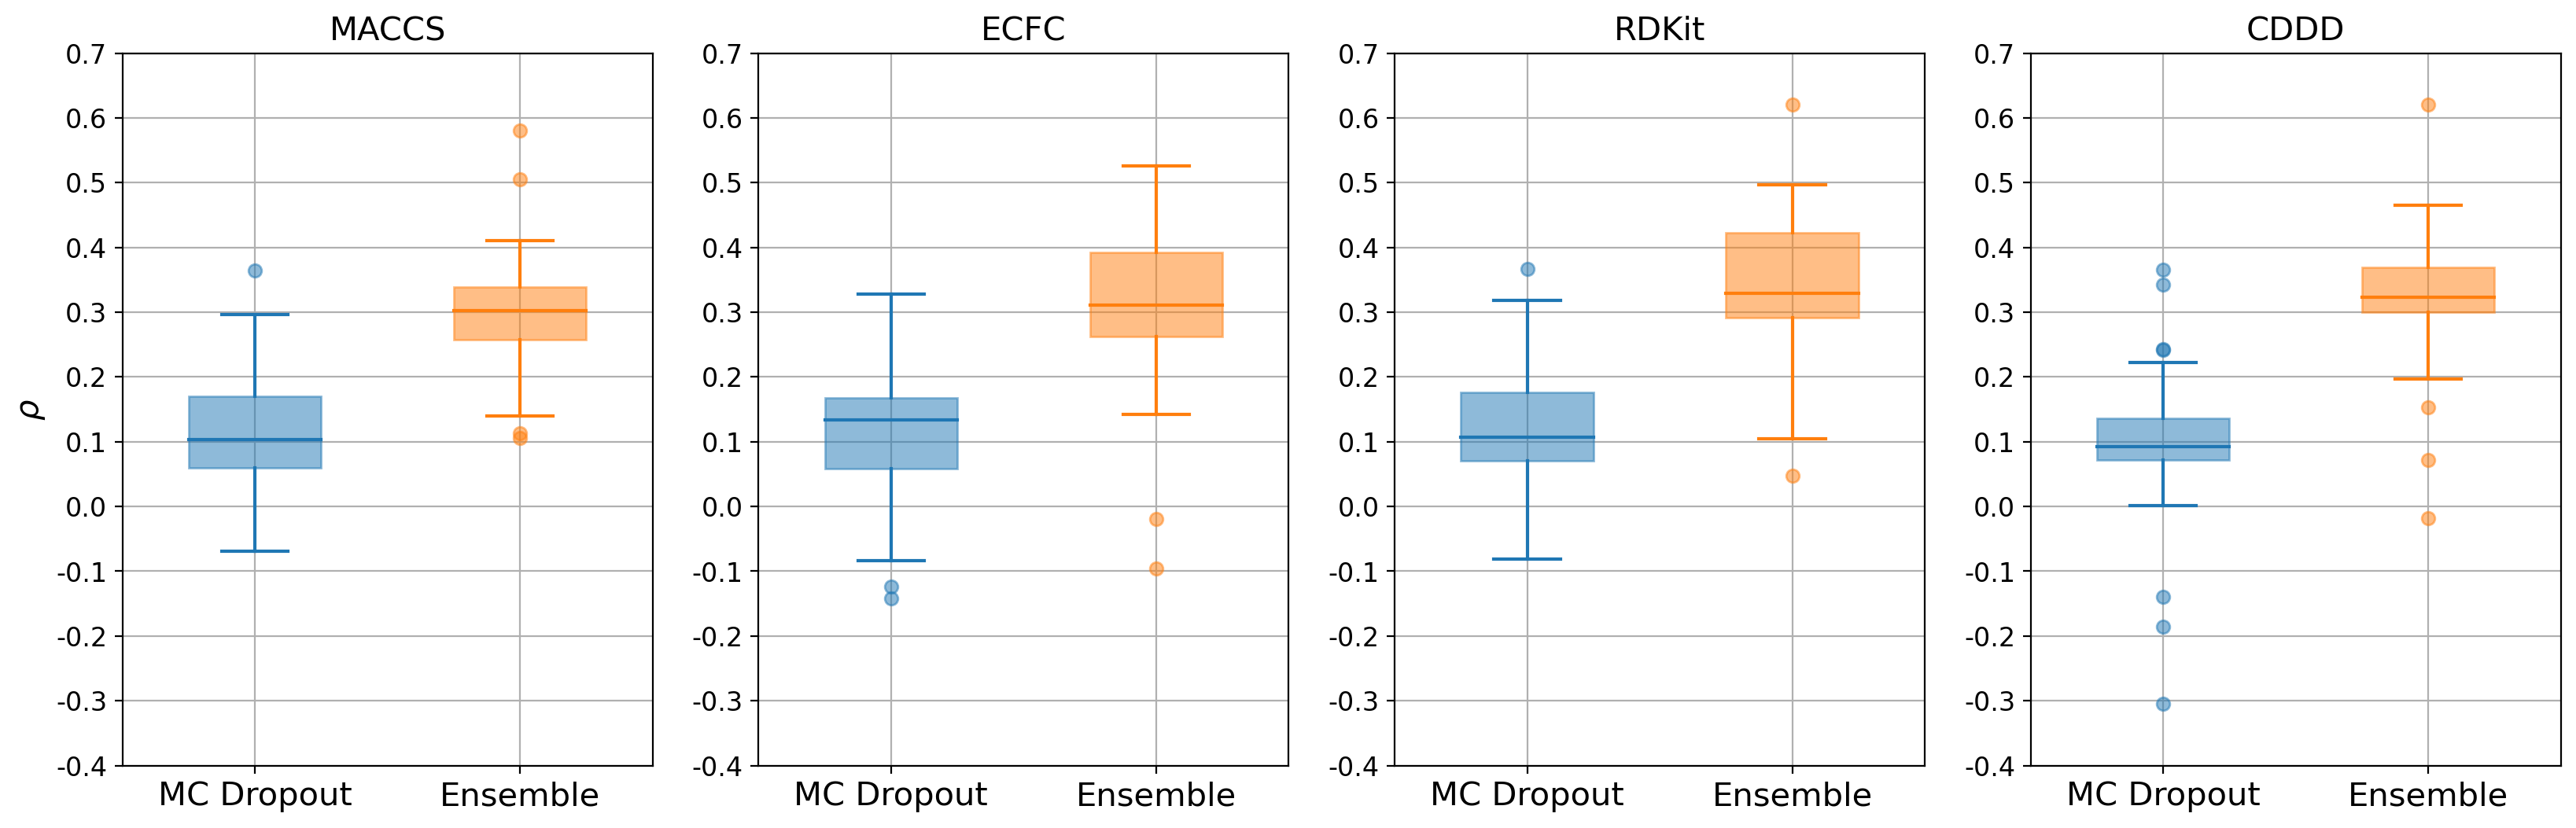

In [10]:
fix, axes = plt.subplots(1, len(descriptors), figsize=(20, 6))

for i in range(len(axes)):
    ax = axes[i]
    descriptor = descriptor_names[i]
    title = descriptor
    dropout_table = complete_overview_dropout[complete_overview_dropout['descriptor'] == descriptor]
    ensemble_table = complete_overview_ensemble[complete_overview_ensemble['descriptor'] == descriptor]
    ax.grid(zorder=1000)
    for j, table in enumerate([dropout_table, ensemble_table]):
        flierprops = {'markerfacecolor':f'C{j}', 'markeredgecolor':f'C{j}', 'alpha':.5}
        box = ax.boxplot(table['rho'], flierprops=flierprops, positions=[j], widths=[.5], patch_artist=True)
        for k, patch in enumerate(box['boxes']):
            patch.set_facecolor(f'C{j}')
            patch.set_edgecolor(f'C{j}')
            patch.set_alpha(.5)
        for patch in box['medians']:
            patch.set_color(f'C{j}')
            patch.set_linewidth(1.5)
        for item in ['whiskers', 'fliers', 'caps']:
            for patch in box[item]:
                patch.set_color(f'C{j}')
                patch.set_linewidth(1.5)
    ax.set_ylim((-.4, .7))
    ax.set_title(title, size=15)
    ax.set_xticklabels(['MC Dropout', 'Ensemble'], size=15)
    rang_adjusted = make_y_range((-.4, .7))
    ax.set_yticks(rang_adjusted)
    ax.set_yticklabels(rang_adjusted, size=12)
    if i == 0:
        ax.set_ylabel(r'$\rho$', size=15)
plt.savefig(PLOT_FOLDER+'dropout_vs_ensemble/rho.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

#### Both

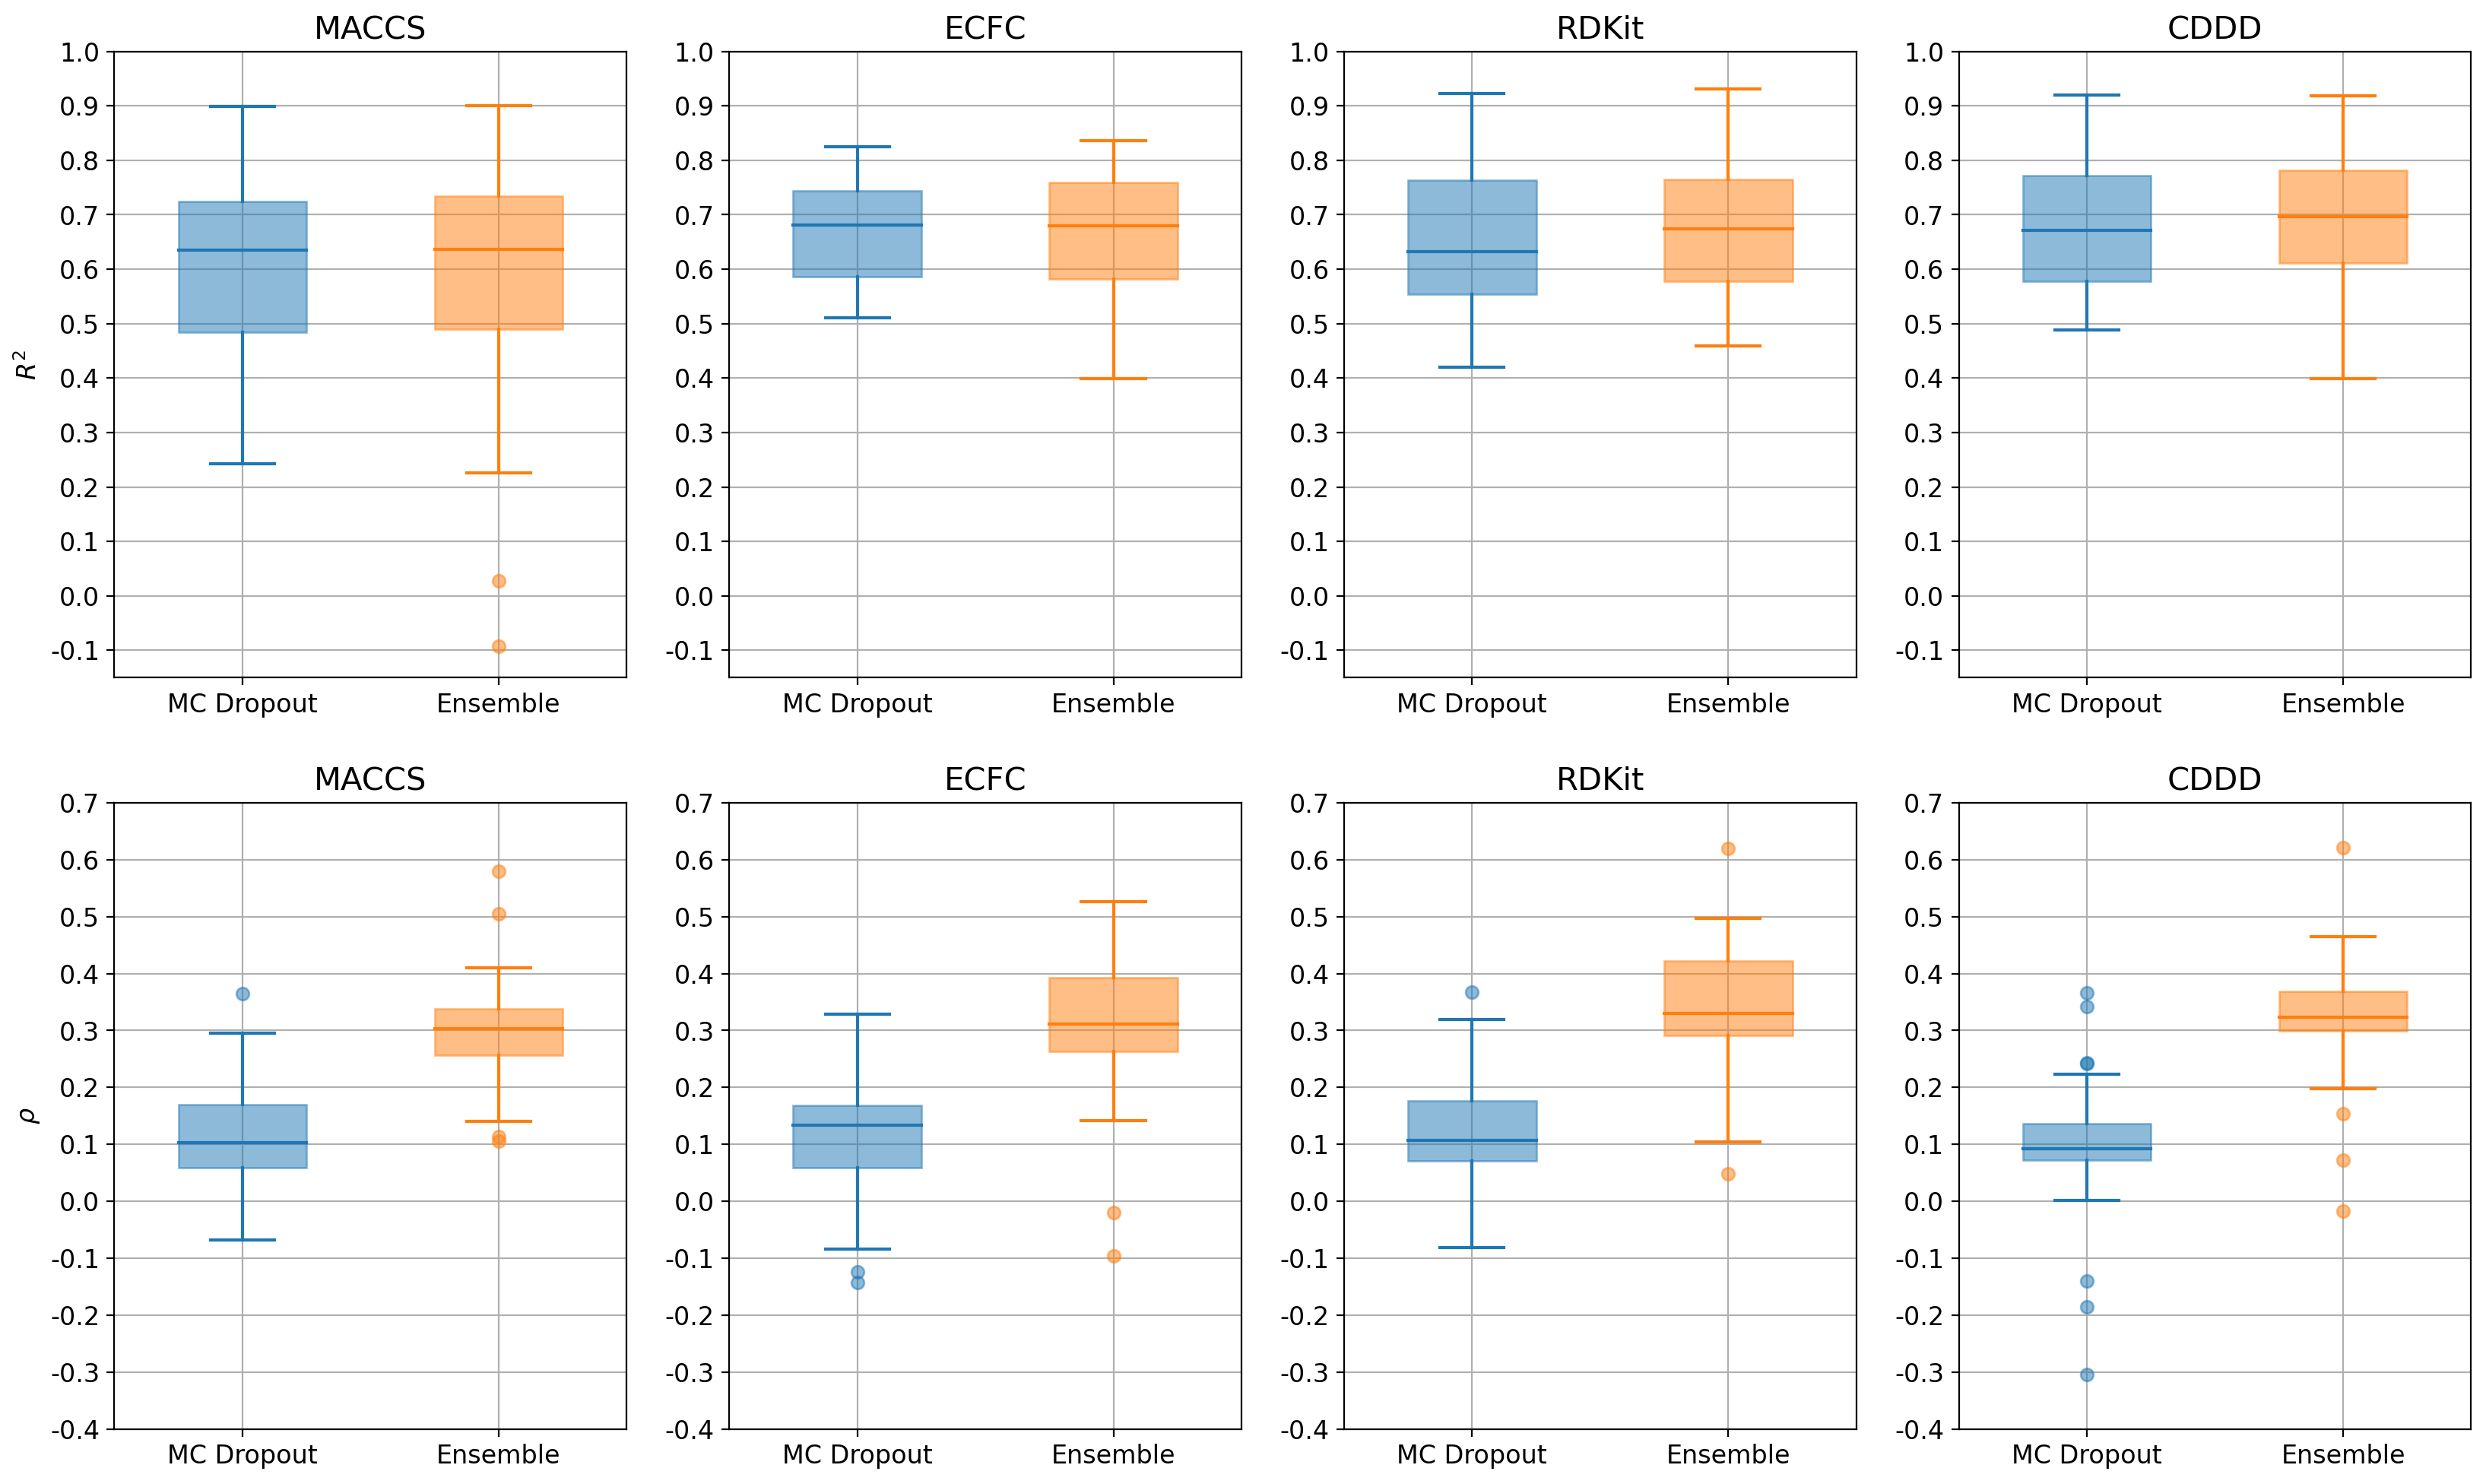

In [11]:
fix, (r2_axes, rho_axes) = plt.subplots(2, len(descriptors), figsize=(20, 12))

for i in range(len(r2_axes)):
    ax = r2_axes[i]
    descriptor = descriptor_names[i]
    title = descriptor
    dropout_table = complete_overview_dropout[complete_overview_dropout['descriptor'] == descriptor]
    ensemble_table = complete_overview_ensemble[complete_overview_ensemble['descriptor'] == descriptor]
    ax.grid(zorder=1000)
    for j, table in enumerate([dropout_table, ensemble_table]):
        flierprops = {'markerfacecolor':f'C{j}', 'markeredgecolor':f'C{j}', 'alpha':.5}
        box = ax.boxplot(table['r2'], flierprops=flierprops, positions=[j], widths=[.5], patch_artist=True)
        for k, patch in enumerate(box['boxes']):
            patch.set_facecolor(f'C{j}')
            patch.set_edgecolor(f'C{j}')
            patch.set_alpha(.5)
        for patch in box['medians']:
            patch.set_color(f'C{j}')
            patch.set_linewidth(1.5)
        for item in ['whiskers', 'fliers', 'caps']:
            for patch in box[item]:
                patch.set_color(f'C{j}')
                patch.set_linewidth(1.5)
    ax.set_ylim((-.15, 1.))
    ax.set_title(title, size=15)
    ax.set_xticklabels(['MC Dropout', 'Ensemble'])
    rang_adjusted = make_y_range((-.1, 1.))
    ax.set_yticks(rang_adjusted)
    ax.set_yticklabels(rang_adjusted)
    plt.setp(ax.xaxis.get_majorticklabels(), size=12)
    plt.setp(ax.yaxis.get_majorticklabels(), size=12)
    if i == 0:
        ax.set_ylabel('$R^2$', size=12)
        
for i in range(len(rho_axes)):
    ax = rho_axes[i]
    descriptor = descriptor_names[i]
    title = descriptor
    dropout_table = complete_overview_dropout[complete_overview_dropout['descriptor'] == descriptor]
    ensemble_table = complete_overview_ensemble[complete_overview_ensemble['descriptor'] == descriptor]
    ax.grid(zorder=1000)
    for j, table in enumerate([dropout_table, ensemble_table]):
        flierprops = {'markerfacecolor':f'C{j}', 'markeredgecolor':f'C{j}', 'alpha':.5}
        box = ax.boxplot(table['rho'], flierprops=flierprops, positions=[j], widths=[.5], patch_artist=True)
        for k, patch in enumerate(box['boxes']):
            patch.set_facecolor(f'C{j}')
            patch.set_edgecolor(f'C{j}')
            patch.set_alpha(.5)
        for patch in box['medians']:
            patch.set_color(f'C{j}')
            patch.set_linewidth(1.5)
        for item in ['whiskers', 'fliers', 'caps']:
            for patch in box[item]:
                patch.set_color(f'C{j}')
                patch.set_linewidth(1.5)
    #ax.set_ylim((-.4, .7))
    ax.set_title(title, size=15)
    ax.set_xticklabels(['MC Dropout', 'Ensemble'])
    rang_adjusted = make_y_range((-.4, .7))
    ax.set_yticks(rang_adjusted)
    ax.set_yticklabels(rang_adjusted)
    plt.setp(ax.xaxis.get_majorticklabels(), size=12)
    plt.setp(ax.yaxis.get_majorticklabels(), size=12)
    if i == 0:
        ax.set_ylabel(r'$\rho$', size=12)
        
plt.savefig(PLOT_FOLDER+'dropout_vs_ensemble/dropout_comparison_summary.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

#### Compare dropout performances with ensemble performances

In [22]:
dropout_predictive = complete_overview_dropout['r2'].values
dropout_uncertainty = complete_overview_dropout['rho'].values

ensemble_predictive = complete_overview_ensemble['r2'].values
ensemble_uncertainty = complete_overview_ensemble['rho'].values

pred_dropout_better_than_ensembles = 0
pred_ensembles_better_than_dropout = 0

pred_dr_ens_diffs = list()
pred_ens_dr_diffs = list()

print('?   Drp    Ens')
for d_p, e_p in zip(dropout_predictive, ensemble_predictive):
    if d_p > e_p:
        print(f'   {d_p:.3f}  {e_p:.3f}')
        pred_dropout_better_than_ensembles += 1
        pred_dr_ens_diffs.append(d_p - e_p)
    else:
        print(f'X  {d_p:.3f}  {e_p:.3f}')
        pred_ensembles_better_than_dropout += 1
        pred_ens_dr_diffs.append(e_p - d_p)

print()
print(f'{pred_dropout_better_than_ensembles} times, dropout achieved a higher predictive performance than ensembles.')
print(f'Differences range from {min(pred_dr_ens_diffs):.3f} to {max(pred_dr_ens_diffs):.3f}, with a median of {median(pred_dr_ens_diffs):.3f}.')
print(f'{pred_ensembles_better_than_dropout} times, ensembles achieved a higher predictive performance than dropout.')
print(f'Differences range from {min(pred_ens_dr_diffs):.3f} to {max(pred_ens_dr_diffs):.3f}, with a median of {median(pred_ens_dr_diffs):.3f}.')

?   Drp    Ens
X  0.769  0.784
X  0.769  0.772
X  0.853  0.860
X  0.856  0.859
X  0.898  0.900
   0.728  0.684
X  0.922  0.931
   0.919  0.917
   0.830  0.826
   0.793  0.784
X  0.902  0.912
X  0.906  0.919
   0.349  0.027
   0.563  0.399
   0.520  0.459
   0.518  0.399
   0.475  0.226
   0.563  0.536
X  0.495  0.539
   0.572  0.477
   0.242  -0.092
   0.621  0.484
X  0.630  0.674
X  0.641  0.660
X  0.488  0.513
X  0.558  0.595
X  0.485  0.542
X  0.535  0.581
X  0.655  0.666
X  0.725  0.744
X  0.659  0.683
X  0.719  0.728
X  0.677  0.683
X  0.720  0.730
X  0.704  0.714
   0.750  0.745
X  0.628  0.649
X  0.646  0.671
X  0.632  0.675
X  0.641  0.692
X  0.679  0.684
X  0.724  0.746
X  0.691  0.719
X  0.712  0.735
X  0.703  0.718
X  0.686  0.725
X  0.688  0.733
X  0.699  0.752
X  0.685  0.700
X  0.741  0.755
X  0.719  0.733
X  0.745  0.759
   0.512  0.481
   0.629  0.573
X  0.584  0.600
X  0.622  0.669
   0.653  0.624
X  0.674  0.675
   0.660  0.656
X  0.641  0.646
X  0.359  0.392
   0.594

In [23]:
unct_dropout_better_than_ensembles = 0
unct_ensembles_better_than_dropout = 0

unct_dr_ens_diffs = list()
unct_ens_dr_diffs = list()

print('?   Drp    Ens')
for d_p, e_p in zip(dropout_uncertainty, ensemble_uncertainty):
    if d_p > e_p:
        print(f'   {d_p:.3f}  {e_p:.3f}')
        unct_dropout_better_than_ensembles += 1
        unct_dr_ens_diffs.append(d_p - e_p)
    else:
        print(f'X  {d_p:.3f}  {e_p:.3f}')
        unct_ensembles_better_than_dropout += 1
        unct_ens_dr_diffs.append(e_p - d_p)
        
print()
print(f'{unct_dropout_better_than_ensembles} times, dropout achieved a higher uncertainty performance than ensembles.')
print(f'Differences range from {min(unct_dr_ens_diffs):.3f} to {max(unct_dr_ens_diffs):.3f}, with a median of {median(unct_dr_ens_diffs):.3f}.')
print(f'{unct_ensembles_better_than_dropout} times, ensembles achieved a higher uncertainty performance than dropout.')
print(f'Differences range from {min(unct_ens_dr_diffs):.3f} to {max(unct_ens_dr_diffs):.3f}, with a median of {median(unct_ens_dr_diffs):.3f}.')

?   Drp    Ens
X  0.112  0.308
   0.328  0.326
X  0.266  0.466
X  0.243  0.434
X  0.364  0.580
X  0.285  0.411
X  0.367  0.620
X  0.343  0.621
X  0.069  0.289
X  0.064  0.158
X  0.158  0.432
X  0.241  0.364
X  -0.038  0.114
X  0.043  0.142
X  0.119  0.311
X  0.089  0.271
X  0.076  0.140
X  0.162  0.265
X  0.190  0.232
X  0.105  0.197
X  0.131  0.375
X  0.240  0.388
X  0.074  0.272
X  0.167  0.302
X  0.078  0.296
X  -0.028  0.229
X  0.015  0.291
X  0.019  0.300
X  0.116  0.327
X  0.147  0.348
X  0.154  0.373
X  0.138  0.365
X  0.034  0.284
X  0.011  0.279
X  0.012  0.342
X  0.001  0.325
X  0.085  0.310
X  0.167  0.275
X  0.087  0.304
X  0.082  0.322
X  0.188  0.341
X  0.165  0.360
X  0.160  0.380
X  0.136  0.329
X  0.053  0.326
X  0.098  0.406
X  0.087  0.354
X  0.075  0.312
X  0.135  0.311
X  0.071  0.299
X  0.108  0.316
X  0.083  0.337
X  -0.068  0.174
X  -0.124  -0.019
X  -0.061  0.105
X  -0.186  0.072
X  0.094  0.375
X  0.065  0.430
X  0.092  0.490
X  0.097  0.380
X  0.082  0.106
X 